In [9]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers

In [1]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import idx2numpy
import skimage as sk
import scipy
import seaborn as sns

Using TensorFlow backend.


In [2]:
# Reading files 

dataset1 = 'train-images-idx3-ubyte'
dataset2 = 'train-labels-idx1-ubyte'
dataset3 = 't10k-images-idx3-ubyte'
dataset4 = 't10k-labels-idx1-ubyte'

# Convert files into numpy array
train_X = idx2numpy.convert_from_file(dataset1)
train_Y = idx2numpy.convert_from_file(dataset2)
test_X = idx2numpy.convert_from_file(dataset3)
test_Y = idx2numpy.convert_from_file(dataset4)

In [3]:
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)


Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [4]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [5]:
# Functions for various type of augmentation within the dataset

def Rotation(img):
    return sk.transform.rotate(img,30)

def Color_invert(img):
    return sk.util.invert(img)

def Flip(img):
    return np.flip(img)

def Random_Noise(img):
    return sk.util.random_noise(img)

def Contrast_Change(img):
    return sk.exposure.rescale_intensity(img, in_range=(10,120))

def Gamma_Correction(img,gamma=0.4):
    return sk.exposure.adjust_gamma(img,gamma)

def Sigmoid_Correction(img):
    return sk.exposure.adjust_sigmoid(img)


In [6]:
# Function takes image array and integer as input and returns the corresponding augmented image 

def Augmentation(img, n):
    if(n==0):
        return Rotation(img)
    elif(n==1):
        return Color_invert(img)
    elif(n==2):
            return Flip(img)
    elif(n==3):
            return Random_Noise(img)
    elif(n==4):
            return Contrast_Change(img)
    elif(n==5):
            return Gamma_Correction(img)
    elif(n==6):
            return Sigmoid_Correction(img)
    else:
        return img


In [7]:
Title = ["Rotation","Color_invert","Flip","Random_Noise","Contrast_Change","Gamma_Correction","Sigmoid_Correction"]


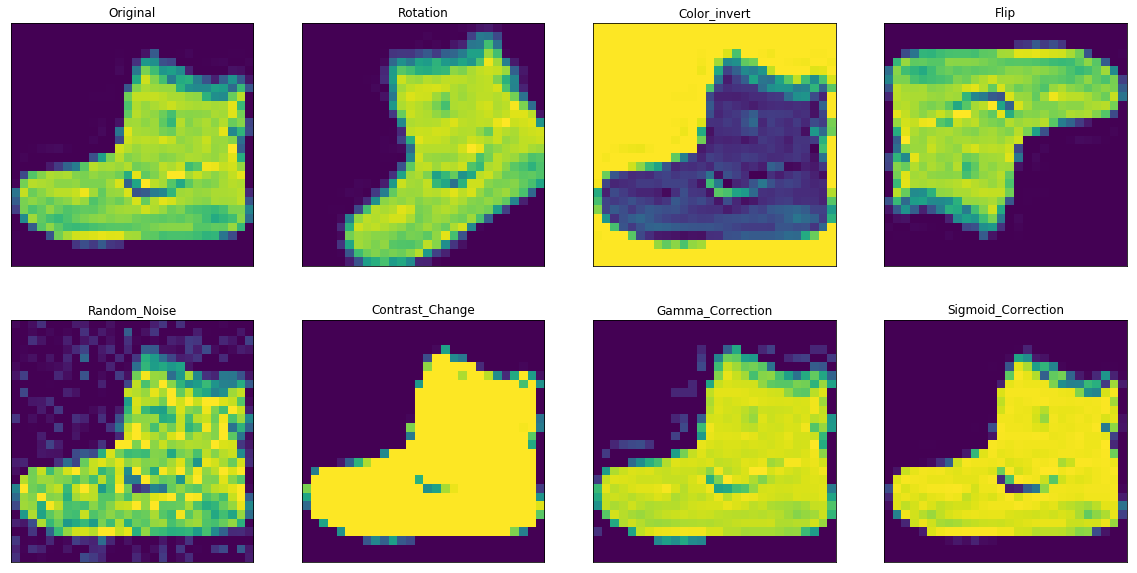

In [8]:
# Visualize augmented images 

plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.imshow(train_X[0,:,:])
plt.xticks([])
plt.yticks([])
plt.title("Original")

for i in range(7):
    plt.subplot(2,4,i+2)
    imx = Augmentation(train_X[0,:,:],i)
    plt.imshow(imx)
    plt.xticks([])
    plt.yticks([])
    plt.title(Title[i])

In [ ]:
################################################################################################

In [58]:
((train_data, train_labels),
 (test_data, test_labels)) = tf.keras.datasets.fashion_mnist.load_data()

In [59]:
target_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

In [60]:
print(train_data.shape)
print(test_data.shape)

(60000, 28, 28)
(10000, 28, 28)


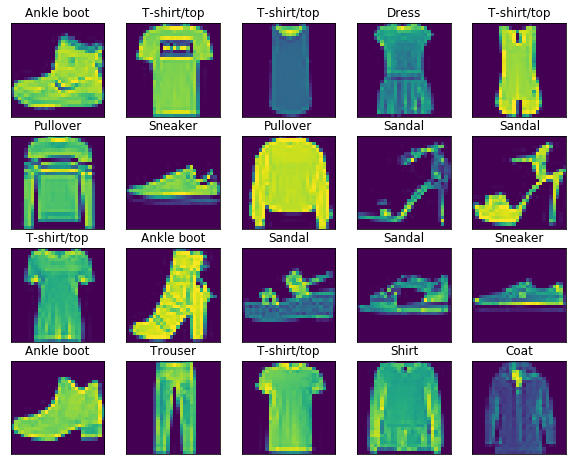

In [61]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(train_data[i] )
    plt.title( target_dict[(train_labels[i]) ])
    plt.xticks([])
    plt.yticks([])

In [62]:
train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)

test_data = test_data/np.float32(255)
test_labels = test_labels.astype(np.int32)

In [63]:
def cnn_model(features, labels, mode):
    #Reshapinng the input
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
     # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    #dropout_1 = tf.layers.dropout(inputs=pool2, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
          inputs= pool2,
          filters=128,
          kernel_size=[5, 5],
        
          padding="same",
          activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    #dropout_2 = tf.layers.dropout(inputs=pool3, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
       
    flatten_1= tf.reshape(pool3, [-1, 3*3*128])
    
    dense = tf.layers.dense(inputs= flatten_1,units=1024,activation=tf.nn.relu)
    
    #dropout= tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    output_layer = tf.layers.dense(inputs= dense, units=10)
    predictions={
    "classes":tf.argmax(input=output_layer, axis=1),
    "probabilities":tf.nn.softmax(output_layer,name='softmax_tensor')
    }
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss= tf.losses.sparse_softmax_cross_entropy(labels=labels, logits= output_layer, scope='loss')
    
    if mode== tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.AdamOptimizer(learning_rate=0.001)
        train_op= optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss,train_op=train_op )
    
    eval_metrics_op={ "accuracy":tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [64]:
fashion_classifier = tf.estimator.Estimator(model_fn = cnn_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3hb7xhp_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa56061f278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [65]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

fashion_classifier.train(input_fn=train_input_fn, steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp3hb7xhp_/model.ckpt.
INFO:tensorflow:loss = 2.3047438, step = 1
INFO:tensorflow:global_step/sec: 5.57742
INFO:tensorflow:loss = 0.57650423, step = 101 (17.930 sec)
INFO:tensorflow:global_step/sec: 5.54552
INFO:tensorflow:loss = 0.43924865, step = 201 (18.033 sec)
INFO:tensorflow:global_step/sec: 5.1886
INFO:tensorflow:loss = 0.34731683, step = 301 (19.273 sec)
INFO:tensorflow:global_step/sec: 4.85458
INFO:tensorflow:loss = 0.3529543, step = 401 (20.599 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp3hb7xhp_/model.ckpt.
INFO:tensorflow:Loss for final step: 0.32376808.


In [67]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_data},
    y=test_labels,
    num_epochs=1,
    shuffle=False)

test_results = fashion_classifier.evaluate(input_fn=test_input_fn)
print(test_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18T08:31:49Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3hb7xhp_/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-08:31:53
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.875, global_step = 500, loss = 0.35198766
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmp3hb7xhp_/model.ckpt-500
{'accuracy': 0.875, 'loss': 0.35198766, 'global_step': 500}


In [19]:
################################################## With dropout #########################################################

In [71]:
def cnn_model_dropout(features, labels, mode):
    #Reshapinng the input
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
     # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    #print(pool1.shape())
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
        
          padding="same",
        
          activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    #print(pool2.shape())
    dropout_1 = tf.layers.dropout(inputs=pool2, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
          inputs= dropout_1,
          filters=128,
          kernel_size=[5, 5],
        
          padding="same",
          activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    #print(pool3.shape())
    dropout_2 = tf.layers.dropout(inputs=pool3, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
       
    flatten_1= tf.reshape(dropout_2, [-1, 3*3*128])
    
    dense = tf.layers.dense(inputs= flatten_1,units=1024,activation=tf.nn.relu)
    
    dropout= tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    output_layer = tf.layers.dense(inputs= dropout, units=10)
    predictions={
    "classes":tf.argmax(input=output_layer, axis=1),
    "probabilities":tf.nn.softmax(output_layer,name='softmax_tensor')
    }
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss= tf.losses.sparse_softmax_cross_entropy(labels=labels, logits= output_layer, scope='loss')
    
    if mode== tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.AdamOptimizer(learning_rate=0.001)
        train_op= optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss,train_op=train_op )
    
    eval_metrics_op={ "accuracy":tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [72]:
fashion_classifier1 = tf.estimator.Estimator(model_fn = cnn_model_dropout)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk_a09rys', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa5685ec6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [73]:
# Train the model
train_input_fn1 = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

fashion_classifier1.train(input_fn=train_input_fn1, steps=100)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.dropout instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpk_a09rys/model.ckpt.
INFO:tensorflow:loss = 2.3061483, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpk_a09rys/model.ckpt.
INFO:tensorflow:Loss for final step: 0.48896936.


In [76]:
test_input_fn1 = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_data},
    y=test_labels,
    num_epochs=1,
    shuffle=False)

test_results1 = fashion_classifier1.evaluate(input_fn = test_input_fn1)
print(test_results1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18T08:44:08Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpk_a09rys/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-08:44:13
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7795, global_step = 100, loss = 0.5880264
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmpk_a09rys/model.ckpt-100
{'accuracy': 0.7795, 'loss': 0.5880264, 'global_step': 100}


In [75]:
################################################ Batch normalization ######################################

In [77]:
def cnn_model_batchnorm(features, labels, mode):
    #Reshapinng the input
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
     # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same"
        )
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.nn.relu(conv1)
    
    pool1 = tf.layers.max_pooling2d(inputs= conv1, pool_size=[2, 2], strides=2)
    #print(pool1.shape())
    
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs = pool1,
          filters = 64,
          kernel_size=[5, 5],
          padding="same"
          )
    conv2 = tf.layers.batch_normalization(conv2)
    conv2 = tf.nn.relu(conv2)
    
    pool2 = tf.layers.max_pooling2d(inputs= conv2, pool_size=[2, 2], strides=2)
    
    
    #dropout_1 = tf.layers.dropout(inputs=pool2, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
          inputs = pool2,
          filters = 128,
          kernel_size = [5, 5],
        
          padding = "same")
    conv3 = tf.layers.batch_normalization(conv3)
    conv3 = tf.nn.relu(conv3)
    pool3 = tf.layers.max_pooling2d(inputs= conv3, pool_size=[2, 2], strides=2)
    
    
    
    #dropout_2 = tf.layers.dropout(inputs=pool3, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
       
    flatten_1= tf.reshape(pool3, [-1, 3*3*128])
    
    dense = tf.layers.dense(inputs= flatten_1,units=1024,activation=tf.nn.relu)
    
    #dropout= tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    output_layer = tf.layers.dense(inputs= dense, units=10)
    predictions={
    "classes":tf.argmax(input=output_layer, axis=1),
    "probabilities":tf.nn.softmax(output_layer,name='softmax_tensor')
    }
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss= tf.losses.sparse_softmax_cross_entropy(labels=labels, logits= output_layer, scope='loss')
    
    if mode== tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.AdamOptimizer(learning_rate=0.001)
        train_op= optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss,train_op=train_op )
    
    eval_metrics_op={ "accuracy":tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [78]:
fashion_classifier2 = tf.estimator.Estimator(model_fn = cnn_model_batchnorm)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdhriist9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa55854a710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [79]:
# Train the model
train_input_fn2 = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

fashion_classifier2.train(input_fn=train_input_fn2, steps=1500)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.batch_normalization instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdhriist9/model.ckpt.
INFO:tensorflow:loss = 2.309874, step = 1
INFO:tensorflow:global_step/sec: 4.77742
INFO:tensorflow:loss = 0.43066102, step = 101 (20.933 sec)
INFO:tensorflow:global_step/sec: 4.85823
INFO:tensorflow:loss = 0.47276193, step = 201 (20.583 sec)
INFO:tensorflow:global_step/sec: 4.67869
INFO:tensorflow:loss = 0.4541686, step = 301 (21.373 sec)
INFO:tensorflow:global_step/sec: 4.69204
INFO:tensorflow:loss = 0.29704532, step = 401 (21.313 sec)
INFO:tensorflow:global_step/sec: 4.6991
INFO:tensorflow:loss = 0.16150588, step = 501 (21.280 sec)
INFO:tensorflow:global_step/sec: 4.69335
INFO:tensorflow:loss = 0.3392471, 

In [80]:
test_input_fn2 = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_data},
    y=test_labels,
    num_epochs=1,
    shuffle=False)

test_results2 = fashion_classifier2.evaluate(input_fn=test_input_fn2)
print(test_results2)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18T08:50:42Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdhriist9/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-08:50:48
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.9038, global_step = 1500, loss = 0.26473275
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: /tmp/tmpdhriist9/model.ckpt-1500
{'accuracy': 0.9038, 'loss': 0.26473275, 'global_step': 1500}


In [ ]:
######################################################## Early Stopping #################################################

In [3]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


In [6]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)  

In [7]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=3)
var1 = model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[earlyStop])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 52s 947us/sample - loss: 0.2187 - acc: 0.9179 - val_loss: 0.2029 - val_acc: 0.9260
Epoch 2/10
55000/55000 [==============================] - 51s 930us/sample - loss: 0.2131 - acc: 0.9213 - val_loss: 0.1987 - val_acc: 0.9290
Epoch 3/10
55000/55000 [==============================] - 51s 930us/sample - loss: 0.2104 - acc: 0.9201 - val_loss: 0.2186 - val_acc: 0.9174
Epoch 4/10
55000/55000 [==============================] - 51s 931us/sample - loss: 0.2100 - acc: 0.9211 - val_loss: 0.2012 - val_acc: 0.9274
Epoch 5/10
55000/55000 [==============================] - 50s 915us/sample - loss: 0.2043 - acc: 0.9242 - val_loss: 0.2020 - val_acc: 0.9224
Epoch 00005: early stopping


In [25]:
score = model.evaluate(x_valid, y_valid, verbose=0)

In [26]:
#print loss and accuracy on test dataset
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20196038608253003
Test accuracy: 0.9224


In [27]:
score_test = model.evaluate(x_test, y_test, verbose=0)

In [28]:
#print loss and accuracy on test dataset
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Test loss: 0.2174538776576519
Test accuracy: 0.9213


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


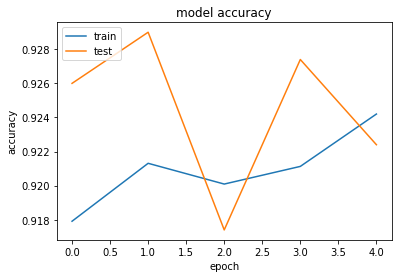

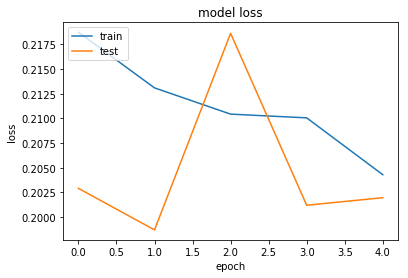

In [40]:
# list all data in history
print(var1.history.keys())
# summarize history for accuracy
plt.plot(var1.history['acc'])
plt.plot(var1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(var1.history['loss'])
plt.plot(var1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
########################################ReduceLROnPlateau#######################################

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
var2 = model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[reduce_lr])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 48s 868us/sample - loss: 0.2061 - acc: 0.9219 - val_loss: 0.2026 - val_acc: 0.9282
Epoch 2/10
55000/55000 [==============================] - 46s 843us/sample - loss: 0.2061 - acc: 0.9228 - val_loss: 0.2023 - val_acc: 0.9272
Epoch 3/10
55000/55000 [==============================] - 46s 845us/sample - loss: 0.1993 - acc: 0.9240 - val_loss: 0.1948 - val_acc: 0.9286
Epoch 4/10
55000/55000 [==============================] - 46s 841us/sample - loss: 0.1966 - acc: 0.9273 - val_loss: 0.2040 - val_acc: 0.9264
Epoch 5/10
55000/55000 [==============================] - 47s 862us/sample - loss: 0.1933 - acc: 0.9277 - val_loss: 0.1990 - val_acc: 0.9260
Epoch 6/10
55000/55000 [==============================] - 46s 844us/sample - loss: 0.1932 - acc: 0.9264 - val_loss: 0.2044 - val_acc: 0.9254
Epoch 7/10
55000/55000 [==============================] - 46s 843us/sample - loss: 0.1946 - acc: 0.9262 -

In [17]:
score1 = model.evaluate(x_valid, y_valid, verbose=0)

In [18]:
#print loss and accuracy
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.20373607387542725
Test accuracy: 0.9248


In [20]:
score3 = model.evaluate(x_test, y_test, verbose=0)

In [21]:
#print loss and accuracy on test dataset
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Test loss: 0.22186507371664047
Test accuracy: 0.9224


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


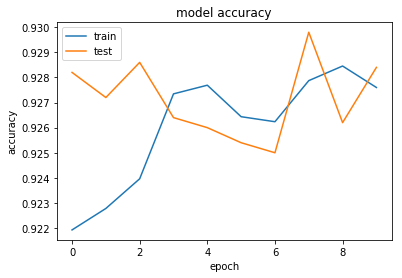

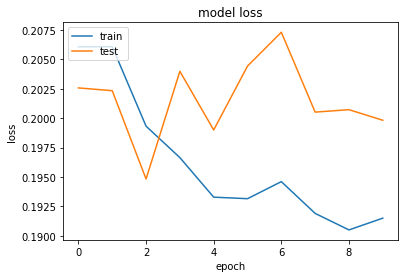

In [41]:
# list all data in history
print(var1.history.keys())
# summarize history for accuracy
plt.plot(var2.history['acc'])
plt.plot(var2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(var2.history['loss'])
plt.plot(var2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
########################################################################################################################